## COAL India Ltd. stock price prediction (Daily)

LSTM used to predict the stock price for COAL India Ltd. based on daily data.

**Programming language**: Python 3

**Framework used**: Keras with TensorFlow backend

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import time
from keras.models import load_model
np.random.seed(21)

Using TensorFlow backend.


## Preprocess data

**Steps**
- Load data with datetime format
- Sort values by date since it is time series data
- Initial entries for `'Change %'` and `'Vol.'` are in object mode; converted to numbers

In [2]:
# load data with datetime index
coal_data = pd.read_csv('../data/COAL India/Weekly/data.csv', parse_dates=[0])

# sort by date
coal_data.sort_values('Date', inplace=True)

# reindex dataframe
coal_data.set_index(keys=['Date'], drop=True, inplace=True)
print('='*40)

# check for missing values
print(coal_data.isnull().sum())
print('='*40)

# convert 'Change %' column entries to numbers
coal_data['Change %'] = coal_data['Change %'].apply(lambda x:float(x.split('%')[0]))

def convert(row):
    '''Function for converting volume entries to numbers
    Input: row ---> Row entry; for ex: 5.1M, 8.22K
    Output num ---> Volume in numbers; for ex: 5.1M to 5100000  
    '''
    if row[-1] == 'M':
        num = float(row[:-1])*1000000
    elif row[-1] == 'K':
        num = float(row[:-1])*1000
    elif row[-1] == '-':
        num = 0
    return num

# convert 'Vol.' column entries to numbers
coal_data['Vol.'] = coal_data['Vol.'].apply(lambda x:convert(x))

coal_data.head()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-07,319.90,351.00,355.7,317.9,44120000.0,-8.51
2010-11-14,331.95,322.00,339.3,309.3,23180000.0,3.77
2010-11-21,312.55,334.65,336.7,301.0,16770000.0,-5.84
2010-11-28,322.30,314.15,326.0,308.2,6860000.0,3.12
2010-12-05,316.70,320.00,324.9,307.5,5120000.0,-1.74


In [3]:
coal_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 429 entries, 2010-11-07 to 2019-01-20
Data columns (total 6 columns):
Price       429 non-null float64
Open        429 non-null float64
High        429 non-null float64
Low         429 non-null float64
Vol.        429 non-null float64
Change %    429 non-null float64
dtypes: float64(6)
memory usage: 23.5 KB


## Visualize trends

It helps to look for seasonality in the data

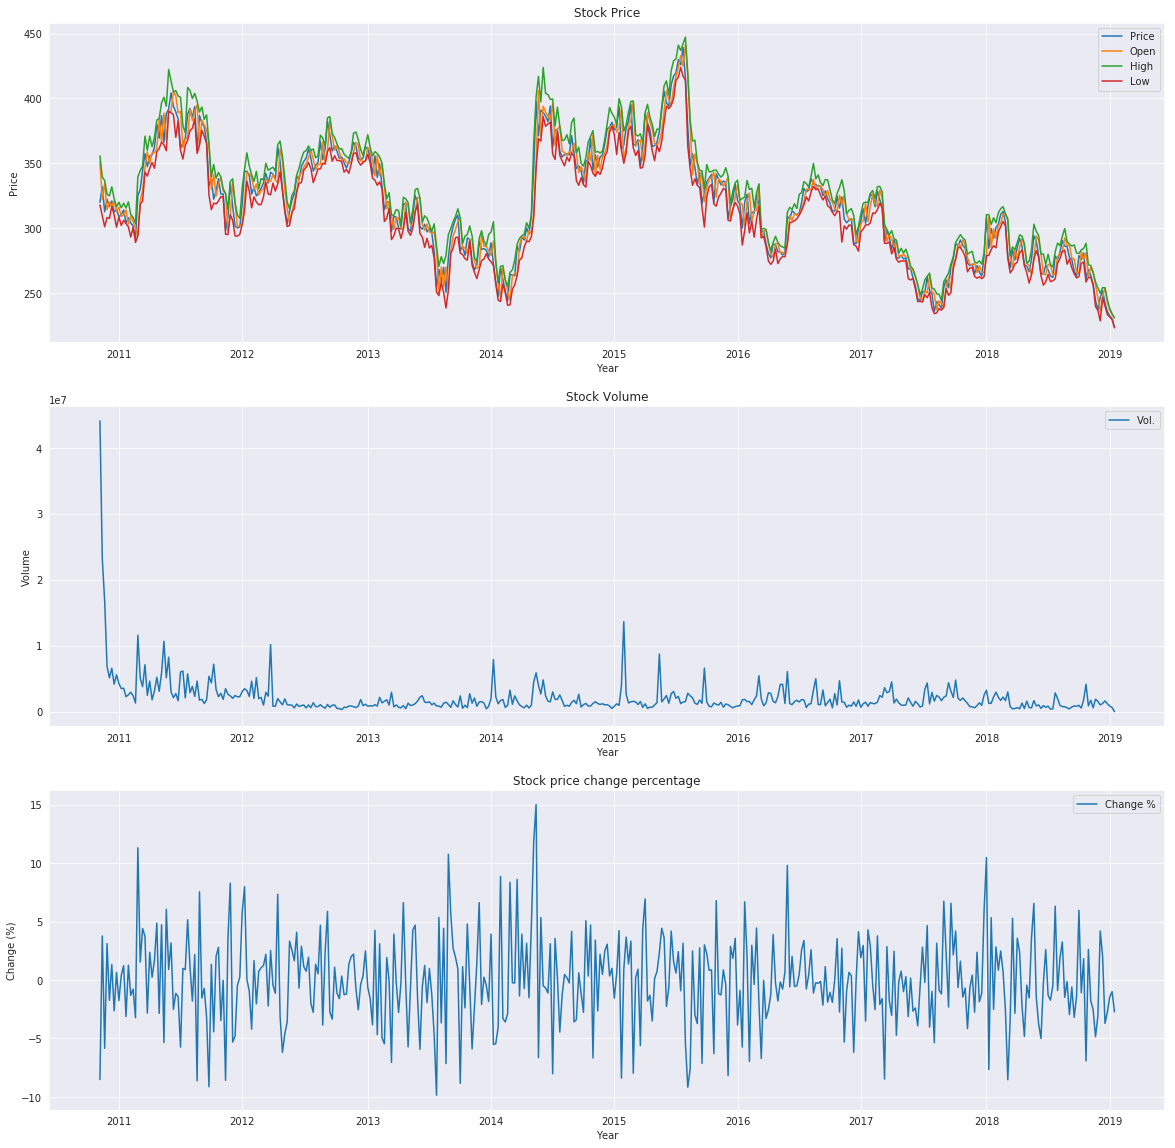

In [4]:
# initialize figure and axes
fig, (ax_1, ax_2, ax_3) = plt.subplots(3,1, figsize=(20,20))

# plot open, close, high and low prices
coal_data.plot(y=['Price', 'Open', 'High', 'Low'], ax=ax_1)
ax_1.set_title('Stock Price')
ax_1.set_xlabel('Year')
ax_1.set_ylabel('Price')

# plot volume
coal_data.plot(y='Vol.', ax=ax_2)
ax_2.set_title('Stock Volume')
ax_2.set_xlabel('Year')
ax_2.set_ylabel('Volume')

# plot percentage change
coal_data.plot(y='Change %', ax=ax_3)
ax_3.set_title('Stock price change percentage')
ax_3.set_xlabel('Year')
ax_3.set_ylabel('Change (%)')

plt.savefig('coal_weekly_trends.png')
# plt.show()

## Normalize with window method and split into training and test

- Training data is 88% and test data is 12%
- Training data is standardized with a window size of 25 with zero mean and unit standard deviation. Accordingly, test data is also standardized

In [5]:
coal_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-07,319.90,351.00,355.7,317.9,44120000.0,-8.51
2010-11-14,331.95,322.00,339.3,309.3,23180000.0,3.77
2010-11-21,312.55,334.65,336.7,301.0,16770000.0,-5.84
2010-11-28,322.30,314.15,326.0,308.2,6860000.0,3.12
2010-12-05,316.70,320.00,324.9,307.5,5120000.0,-1.74


In [6]:
# split data
train_data = coal_data.iloc[:375,:]
test_data = coal_data.iloc[375:,:]

# normalize by splitting into window
window_size = 25
scaler = StandardScaler()

# normalize train data
for di in range(0, len(train_data), window_size):
    scaler.fit(train_data.iloc[di:di+window_size,:])
    train_data.iloc[di:di+window_size,:] = scaler.transform(train_data.iloc[di:di+window_size,:])

# normalize test data
test_data.iloc[:,:] = scaler.transform(test_data.iloc[:,:])

# split into train and test features and targets
X_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0]
X_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0]

In [7]:
X_train.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2010-11-07,1.257742,0.848901,0.111025,4.129395,-2.313590
2010-11-14,-0.168604,0.118702,-0.328171,1.787850,0.871630
2010-11-21,0.453578,0.002939,-0.752047,1.071073,-1.621038
2010-11-28,-0.554701,-0.473472,-0.384348,-0.037080,0.703031
2010-12-05,-0.266973,-0.522449,-0.420096,-0.231650,-0.557569


In [8]:
X_test.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2018-01-14,2.824275,2.250240,1.188704,-0.743392,-2.223597
2018-01-21,1.275936,1.789855,1.471612,-0.724288,1.229672
2018-01-28,2.201044,2.115194,1.643816,0.183170,-0.854518
2018-02-04,1.720637,1.875793,1.545414,0.890032,0.565071
2018-02-11,2.369836,2.342317,2.295734,0.154513,0.036048


In [9]:
y_train.head()

Date
2010-11-07   -0.279982
2010-11-14    0.263476
2010-11-21   -0.611469
2010-11-28   -0.171742
2010-12-05   -0.424303
Name: Price, dtype: float64

In [10]:
y_test.head()

Date
2018-01-14    0.962781
2018-01-21    1.809083
2018-01-28    1.391500
2018-02-04    1.853626
2018-02-11    1.995604
Name: Price, dtype: float64

## Model Building with LSTM using Keras

- LSTM model with 4 hidden layers
- First 3 hidden layers are LSTM layers with 10, 20 and 10 neurons. Final hidden layer is a dense one with 10 neurons
- Output layer is a dense layer with single output predicting the stock value
- Use of dropout (to prevent overfitting) with ReLU activation in hidden layers and linear activation in the output layer
- Optimizer used is Adam with Mean Squared Error (MSE) as the loss to minimize
- Weights are initialized randomly within the network
- Model is trained on 95% of training data and validated of rest 5% of it. Total passes/epochs is 150

In [11]:
# initialize model with Keras
model = Sequential()

# add 3 LSTM layers with dropout
model.add(LSTM(input_dim=5, output_dim=10, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.25))

# add Dense layer with ReLU activation
model.add(Dense(10,kernel_initializer="uniform",activation='relu'))        

# add Dense layer with Linear activation
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# start time
start = time.time()

# compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# model compilation time
print ('compilation time : ', time.time() - start)

compilation time :  0.058519601821899414


In [12]:
# Fit model on training data with validation data 5% of training data and 150 epochs
model.fit(X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]),y_train, nb_epoch=150, validation_split=0.05, batch_size=10)

Train on 356 samples, validate on 19 samples
Epoch 1/150
356/356 [==============================] - 5s 14ms/step - loss: 1.0147 - mean_squared_error: 1.0147 - val_loss: 0.7270 - val_mean_squared_error: 0.7270
Epoch 2/150
356/356 [==============================] - 1s 2ms/step - loss: 1.0128 - mean_squared_error: 1.0128 - val_loss: 0.7299 - val_mean_squared_error: 0.7299
Epoch 3/150
356/356 [==============================] - 1s 2ms/step - loss: 0.9902 - mean_squared_error: 0.9902 - val_loss: 0.7071 - val_mean_squared_error: 0.7071
Epoch 4/150
356/356 [==============================] - 1s 2ms/step - loss: 0.8462 - mean_squared_error: 0.8462 - val_loss: 0.6134 - val_mean_squared_error: 0.6134
Epoch 5/150
356/356 [==============================] - 1s 2ms/step - loss: 0.4990 - mean_squared_error: 0.4990 - val_loss: 0.4696 - val_mean_squared_error: 0.4696
Epoch 6/150
356/356 [==============================] - 1s 2ms/step - loss: 0.3174 - mean_squared_error: 0.3174 - val_loss: 0.3111 - val_mea

Epoch 51/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 52/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0304 - val_mean_squared_error: 0.0304
Epoch 53/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0884 - mean_squared_error: 0.0884 - val_loss: 0.0314 - val_mean_squared_error: 0.0314
Epoch 54/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0779 - mean_squared_error: 0.0779 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 55/150
356/356 [==============================] - 1s 2ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - val_loss: 0.0277 - val_mean_squared_error: 0.0277
Epoch 56/150
356/356 [==============================] - 1s 2ms/step - loss: 0.0761 - mean_squared_error: 0.0761 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 57/150
356

Epoch 101/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0816 - mean_squared_error: 0.0816 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 102/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.0219 - val_mean_squared_error: 0.0219
Epoch 103/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0851 - mean_squared_error: 0.0851 - val_loss: 0.0204 - val_mean_squared_error: 0.0204
Epoch 104/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0804 - mean_squared_error: 0.0804 - val_loss: 0.0179 - val_mean_squared_error: 0.0179
Epoch 105/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0180 - val_mean_squared_error: 0.0180
Epoch 106/150
356/356 [==============================] - 1s 3ms/step - loss: 0.0814 - mean_squared_error: 0.0814 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 107/

## Making predictions with LSTM
- Predicted stock prices are scaled back to original scale

In [13]:
# make predictions
y_pred = model.predict(X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1]))

# create copy of original test data to rescale data into original format
test_predictions = test_data.copy()

# set 'Price' feature value as predicted values
test_predictions[['Price']] = y_pred

# inverse transform predictions data
test_predictions.iloc[:,:] = scaler.inverse_transform(test_predictions)
preds = test_predictions.iloc[:,0]

# inverse transform original test data
test_data.iloc[:,:] = scaler.inverse_transform(test_data)
actual = test_data.iloc[:,0]

In [14]:
print(preds)

Date
2018-01-14    284.397312
2018-01-21    298.531174
2018-01-28    291.814976
2018-02-04    296.045738
2018-02-11    299.026539
2018-02-18    301.252993
2018-02-25    300.935762
2018-03-04    297.500412
2018-03-11    278.898097
2018-03-18    267.948971
2018-03-25    286.892012
2018-04-01    275.683098
2018-04-08    287.925575
2018-04-15    292.331099
2018-04-22    286.361161
2018-04-29    273.121502
2018-05-06    270.466787
2018-05-13    263.109309
2018-05-20    277.749226
2018-05-27    296.936233
2018-06-03    289.311499
2018-06-10    281.612908
2018-06-17    263.984340
2018-06-24    264.318489
2018-07-01    269.741159
2018-07-08    269.518669
2018-07-15    262.713684
2018-07-22    262.338806
2018-07-29    280.656212
2018-08-05    278.359851
2018-08-12    286.005769
2018-08-19    292.307500
2018-08-26    289.534347
2018-09-02    285.229129
2018-09-09    279.149608
2018-09-16    277.257467
2018-09-23    269.473577
2018-09-30    265.722193
2018-10-07    282.018047
2018-10-14    278.70

In [15]:
print(actual)

Date
2018-01-14    284.45
2018-01-21    299.65
2018-01-28    292.15
2018-02-04    300.45
2018-02-11    303.00
2018-02-18    310.55
2018-02-25    312.80
2018-03-04    304.70
2018-03-11    278.70
2018-03-18    269.25
2018-03-25    283.50
2018-04-01    275.45
2018-04-08    285.35
2018-04-15    292.05
2018-04-22    285.55
2018-04-29    271.75
2018-05-06    270.55
2018-05-13    266.40
2018-05-20    276.05
2018-05-27    294.15
2018-06-03    289.90
2018-06-10    279.05
2018-06-17    265.10
2018-06-24    264.40
2018-07-01    271.30
2018-07-08    267.75
2018-07-15    263.15
2018-07-22    261.95
2018-07-29    278.50
2018-08-05    276.00
2018-08-12    281.20
2018-08-19    290.40
2018-08-26    286.10
2018-09-02    285.75
2018-09-09    277.30
2018-09-16    275.65
2018-09-23    266.85
2018-09-30    263.05
2018-10-07    278.75
2018-10-14    275.75
2018-10-21    280.80
2018-10-28    261.35
2018-11-04    268.20
2018-11-11    263.45
2018-11-18    256.75
2018-11-25    244.30
2018-12-02    236.80
2018-12-

## Calculating Root Mean-Squared-Error on test data

In [16]:
# calculate mean squared error on test data
error = np.sqrt(mean_squared_error(preds, actual))
print(error)

3.273386213939936


## Comparing original and predicted prices

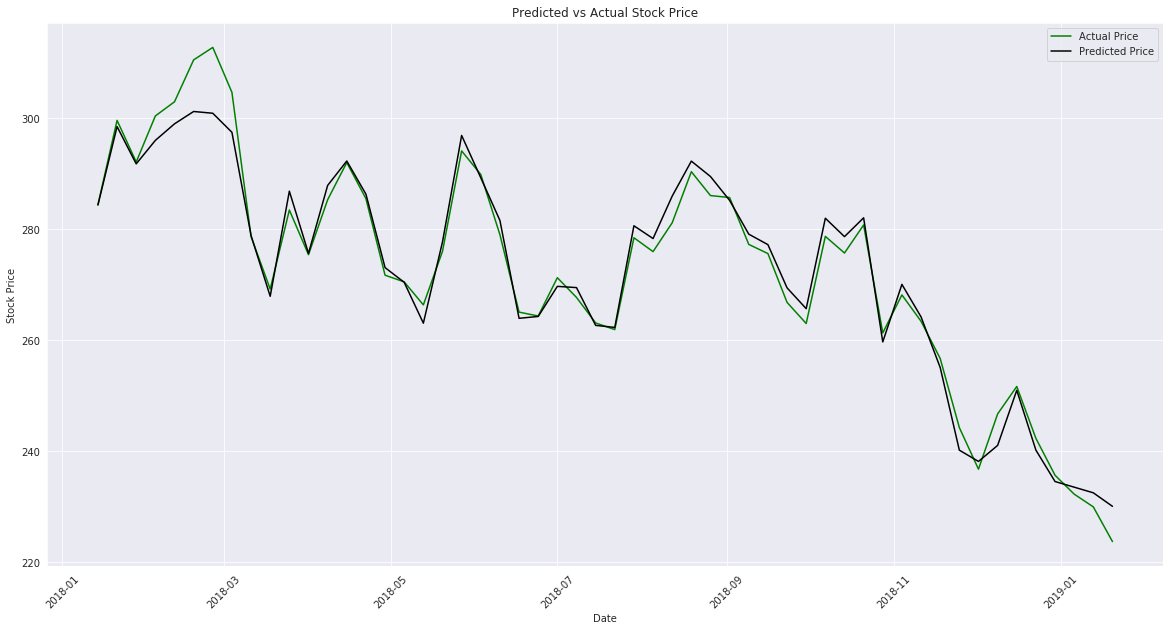

In [17]:
# comapre original vs predicted stock prices
plt.figure(figsize=(20,10))
plt.plot(actual, color='green')
plt.plot(preds, color='black')
plt.legend(['Actual Price', 'Predicted Price'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted vs Actual Stock Price')
plt.savefig('coal_weekly.png')
# plt.show()

## Save it to CSV file

In [18]:
comp = pd.DataFrame({'Actual':actual, 'Predicted':preds}, index=actual.index)
comp.head()

,Actual,Predicted
Date,,
2018-01-14,284.45,284.397312
2018-01-21,299.65,298.531174
2018-01-28,292.15,291.814976
2018-02-04,300.45,296.045738
2018-02-11,303.00,299.026539


In [20]:
comp.to_csv('coal_weekly.csv')